# Linear Tree

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from lineartree import LinearTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from joblib import dump
import numpy as np

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [2]:
train =  pd.read_parquet('../../../data/model_input/train_sets/electricity_transformer.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/electricity_transformer.parquet')

In [3]:
y_train = train.OT_next
X_train = train.drop(columns=['date', 'OT_next'])

In [4]:
y_validation = validation.OT_next
X_validation = validation.drop(columns=['date', 'OT_next'])

In [5]:
scaler = StandardScaler().fit(X_train)

In [6]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [30]:
models_list = [LinearTreeRegressor(base_estimator=Ridge(), max_depth=1, max_bins=10), 
                        LinearTreeRegressor(base_estimator=LinearRegression(), max_depth=1, max_bins=10),
                        LinearTreeRegressor(base_estimator=Ridge(), max_depth=2, max_bins=10)]
names_list = ['LT_1_l2', 'LT_1', 'LT_2_l2']

In [28]:
metrics = regression(models_list, names_list, '../../../data/model_output/metrics/electricity_transformer/linear_tree.csv', X_train_scaled, y_train, X_validation_scaled, y_validation)
metrics

,Run_Time,Train_RMSE,Validation_RMSE,delta%
LT_1_l2,199.745347,0.478405,0.299265,-37.445354
LT_1,714.291826,0.478261,0.298426,-37.601839
LT_2_l2,253.214748,0.476086,0.299306,-37.131954


As we can see, these type of models for this dataset are extemely expensive on computing time, so we are only fitting this three models of just depth 1 or 2 and with the modification of 10 maximum bins or searching the best splitting value. We choose **LT_1_l2** because is the faster one.

In [7]:
test =  pd.read_parquet('../../../data/model_input/test_sets/electricity_transformer.parquet')

In [8]:
y_test = test.OT_next
X_test = test.drop(columns=['date', 'OT_next'])

In [9]:
retrain = pd.concat([train, validation])

In [10]:
y_retrain = retrain.OT_next
X_retrain = retrain.drop(columns=['date', 'OT_next'])

In [11]:
scaler_retrain = StandardScaler().fit(X_retrain)

In [12]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [39]:
model = LinearTreeRegressor(base_estimator=Ridge(), max_depth=1, max_bins=10).fit(X_retrain_scaled, y_retrain)

In [40]:
test_pred = model.predict(X_test_scaled)
rmse = root_mean_squared_error(y_test, test_pred)
print('Test RMSE:', round(rmse, 4))

Test RMSE: 0.3266


In [41]:
dump(model, '../../../data/model_output/models/electricity_transformer/best_linear_tree.joblib')

['best_linear_tree.joblib']

In [42]:
with open('../../../data/model_output/metrics/electricity_transformer/final_RMSE.txt', 'a') as f:
    f.write('\nLT, '+ str(rmse))

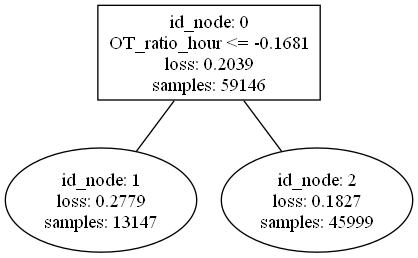

In [44]:
model.plot_model(feature_names=X_retrain.columns)

In [49]:
leaves = model.summary(only_leaves=True)

In [53]:
top_threshold1 = 1.5
top_coefficients1 = [coef for coef in leaves[1]['models'].coef_.ravel() if abs(coef) > top_threshold1]
top_features1 = [name for name, coef in zip(X_retrain.columns, leaves[1]['models'].coef_.ravel()) if abs(coef) > top_threshold1]

In [54]:
labels1 = [' ' if feature not in top_features1 else feature for feature in X_retrain.columns]

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_3296/3739103079.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels1, rotation=90, ha='right')


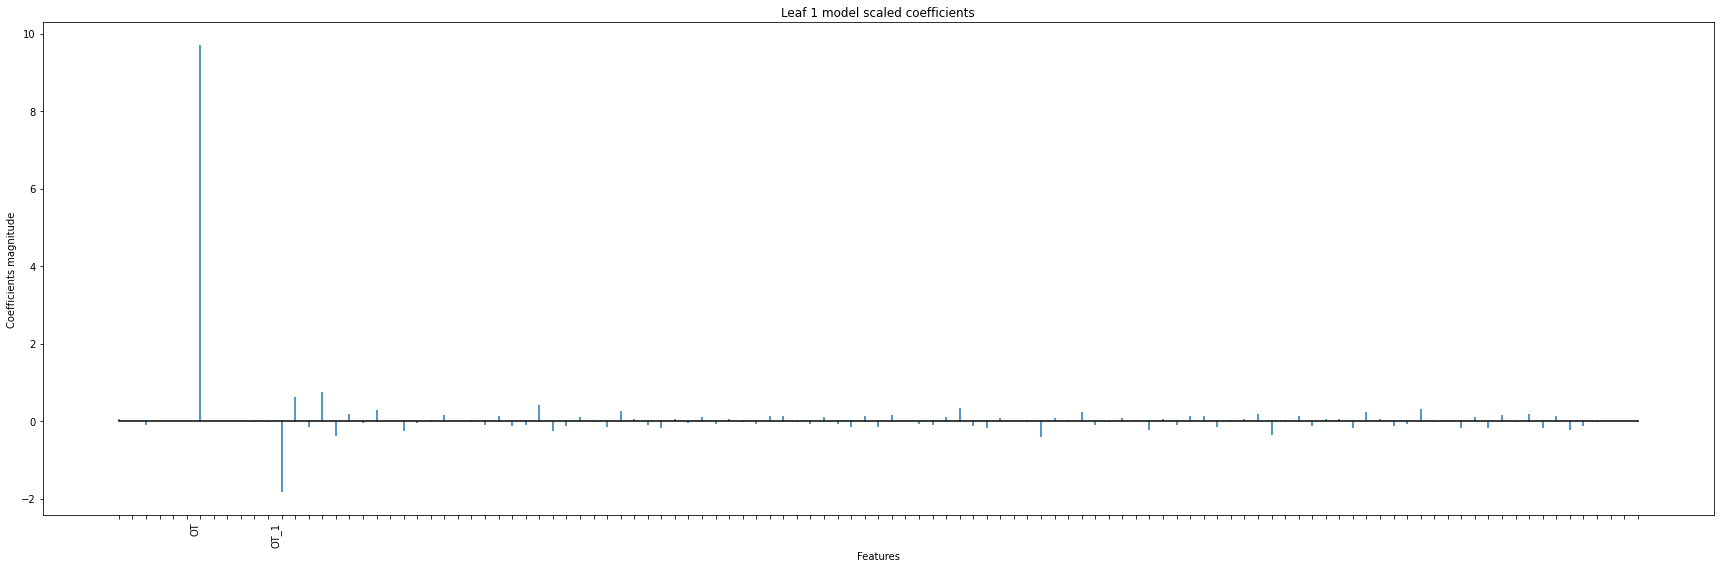

In [55]:
fig, ax = plt.subplots(figsize=(24, 8))
ax.stem(X_retrain.columns, leaves[1]['models'].coef_.ravel(), markerfmt=' ', basefmt='k-')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('Leaf 1 model scaled coefficients')
ax.set_xticklabels(labels1, rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [56]:
top_threshold2 = 1.5
top_coefficients2 = [coef for coef in leaves[2]['models'].coef_.ravel() if abs(coef) > top_threshold2]
top_features2 = [name for name, coef in zip(X_retrain.columns, leaves[2]['models'].coef_.ravel()) if abs(coef) > top_threshold2]

In [57]:
labels2 = [' ' if feature not in top_features2 else feature for feature in X_retrain.columns]

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_3296/2510691937.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels2, rotation=90, ha='right')


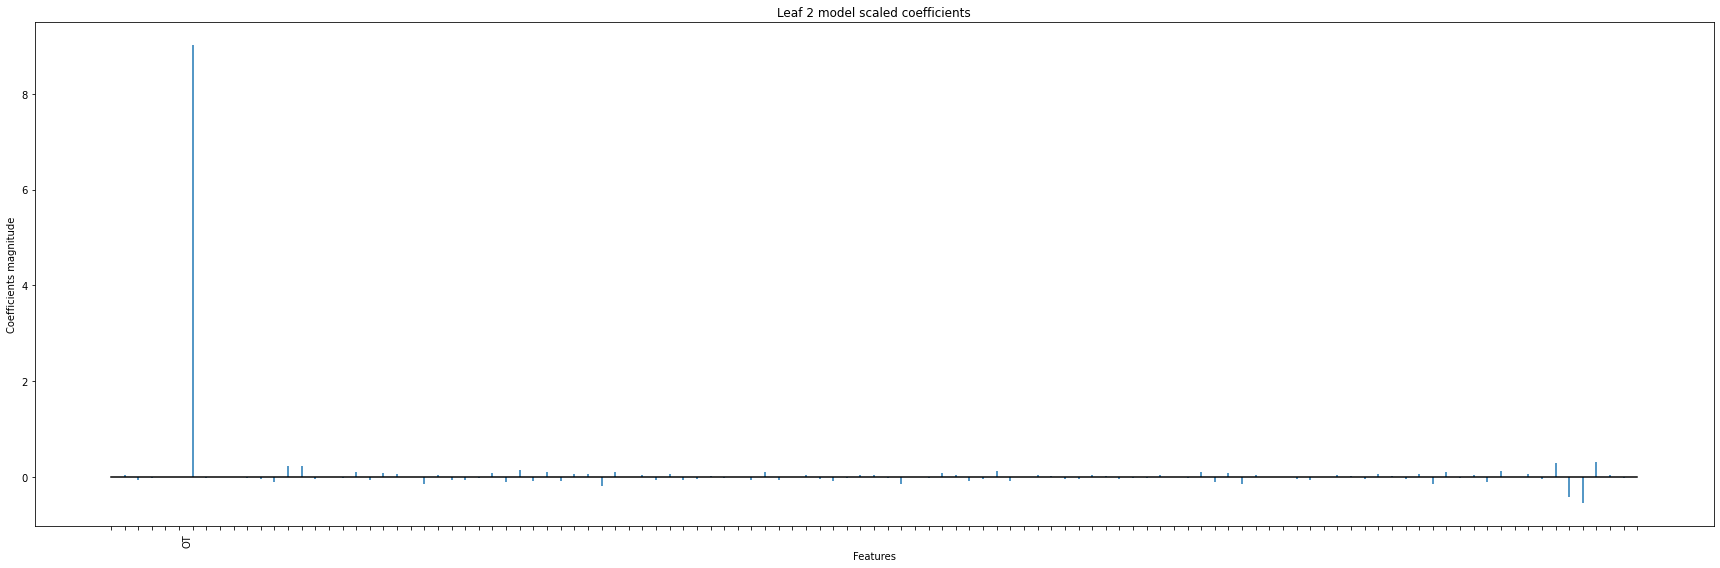

In [58]:
fig, ax = plt.subplots(figsize=(24, 8))
ax.stem(X_retrain.columns, leaves[2]['models'].coef_.ravel(), markerfmt=' ', basefmt='k-')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('Leaf 2 model scaled coefficients')
ax.set_xticklabels(labels2, rotation=90, ha='right')
plt.tight_layout()
plt.show()

Both leaves are fitting a very similar linear model, this is due to the high correlation between our target and the OT feature

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_3296/1387393881.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],


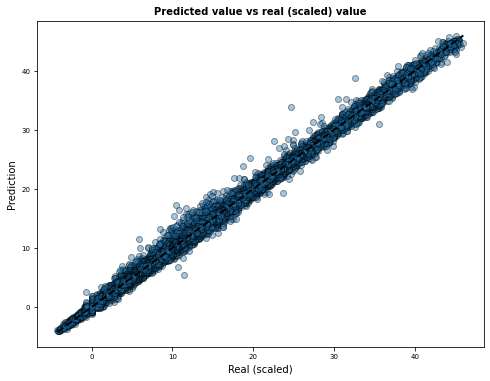

In [65]:
prediction_retrain = model.predict(X_retrain_scaled)
error_retrain   = prediction_retrain - y_retrain

plt.figure(figsize=(8, 6))

plt.scatter(y_retrain, prediction_retrain, edgecolors=(0, 0, 0), alpha = 0.4)
plt.plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],
                'k--', color = 'black', lw=2)
plt.title('Predicted value vs real (scaled) value', fontsize = 10, fontweight = "bold")
plt.xlabel('Real (scaled)')
plt.ylabel('Prediction')
plt.tick_params(labelsize = 7)

In [13]:
from joblib import load
load_mod = load('../../../data/model_output/models/electricity_transformer/best_linear_tree.joblib')

train_pred = load_mod.predict(X_retrain_scaled)
rmse_train = root_mean_squared_error(y_retrain, train_pred)
test_pred = load_mod.predict(X_test_scaled)
rmse_test = root_mean_squared_error(y_test, test_pred)

In [14]:
import time 
time1 = time.time()
LinearTreeRegressor(base_estimator=Ridge(), max_depth=1, max_bins=10).fit(X_retrain_scaled, y_retrain)
time2 = time.time() - time1 

with open('../../../data/model_output/metrics/electricity_transformer/final_metrics.txt', 'a') as f:
     f.write(f'\nLT; {time2}; {rmse_train}; {rmse_test}')